Loading BokehJS ...

Processing light curve for sector 71...
Error displaying TPF for sector 71: tuple index out of range
Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 37 durations
Searching 87908 data points, 1606 periods from 1.001 to 11.98 days
Using all 16 CPU threads


100%|█████████████████████████████████████████████████████████████████████████████████| 1606/1606 periods | 01:13<00:00


Searching for best T0 for period 1.09088 days
Orbital Parameters:
  Period: 1.090875 ± 0.005320 days
  Transit Midpoint (t0): 3235.658013 days ± 0.091670
  Duration: 2.29 hours
  Semi-major Axis (a): 0.0189 ± 0.0001 AU
  Transit Depth: 34.25 ± 6.15 ppt, 34247.77 ± 6146.14 ppm
  Radius Ratio (Rp/Rs): 0.1851 ± 0.0166
  Candidate Radius: 103896.78 km, 1.4533 R_Jup
  Candidate Type: Red Dwarf Star
  True Anomaly at Transit: 90.00° ± 3.30°
  Synthetic Companion Mass: 49722.61 ± 4205.75 M_Earth, 156.3604 ± 13.2256 M_Jup


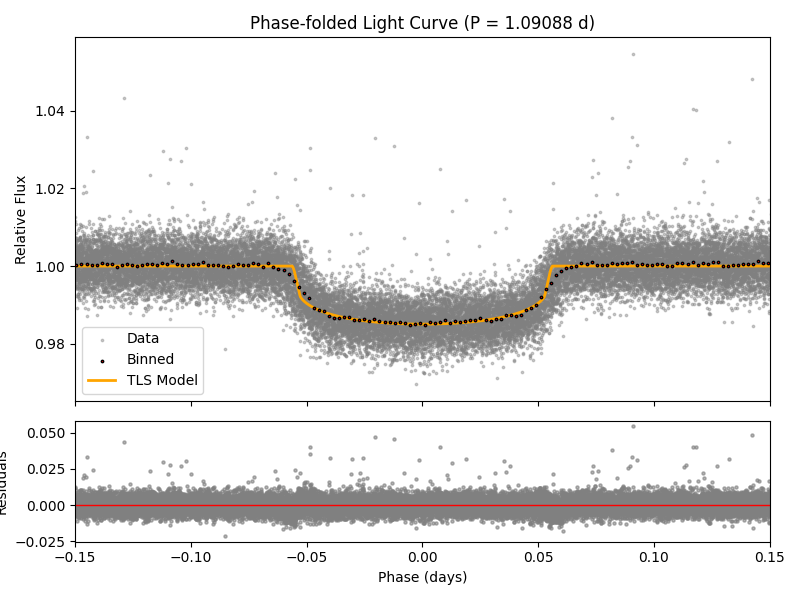

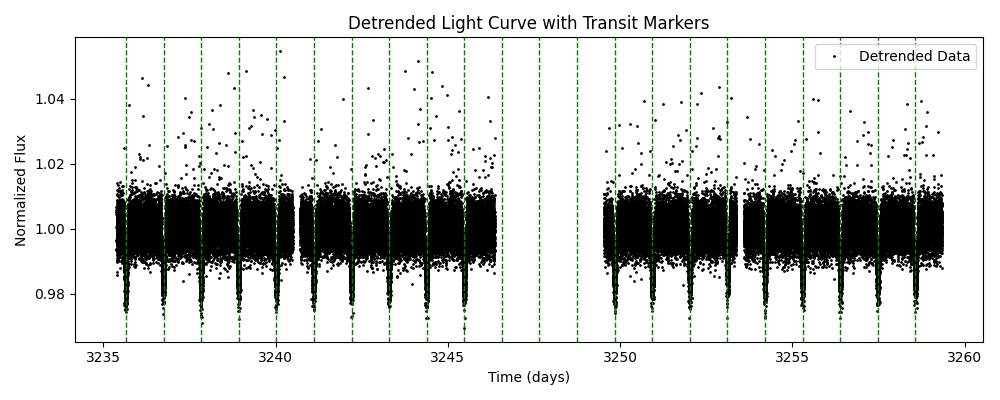

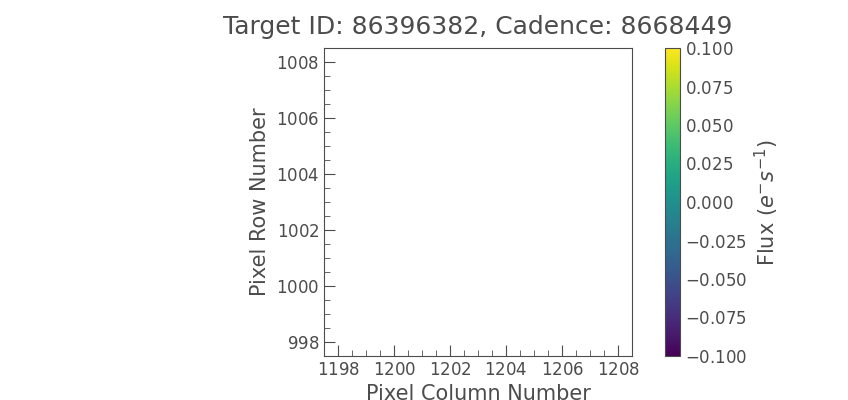

In [9]:
import numpy as np
import lightkurve as lk
from transitleastsquares import transitleastsquares
import warnings
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, push_notebook
from bokeh.layouts import gridplot
from bokeh.models import Span, Label, HoverTool
import matplotlib.pyplot as plt
from astroquery.mast import Catalogs

%matplotlib ipympl
output_notebook()
warnings.simplefilter('ignore')

# Global data arrays
all_time = []
all_flux = []

# --- User-set dilution factor (flux contamination)
# For example, if 11.14% of the total flux comes from contaminants,
# then the true transit depth = measured_depth / (1 - 0.111417)
default_dilution_factor = 0.111417

def gaussian_filter(data, sigma=3.0):
    return gaussian_filter1d(data, sigma=sigma)

def clean_data(time, flux):
    mask = np.isfinite(time) & np.isfinite(flux)
    time_clean = time[mask]
    flux_clean = flux[mask]
    flux_normalized = flux_clean / np.nanmedian(flux_clean)
    return time_clean, flux_normalized

def process_sector(sector, tic_id):
    try:
        print(f"Processing light curve for sector {sector}...")
        search_result = lk.search_lightcurve(f'TIC {tic_id}', mission='TESS', sector=sector)
        if len(search_result) > 0:
            lc_file = search_result.download()
            flux = lc_file.flux.value
            time = lc_file.time.value
            mask = ~np.isnan(flux)
            time = time[mask]
            flux = flux[mask] / np.nanmedian(flux) if np.nanmedian(flux) != 0 else flux
            return time, flux
        else:
            print(f"No light curve data found for sector {sector}")
            return None, None
    except Exception as e:
        print(f"Error processing light curve for sector {sector}: {e}")
        return None, None

def calculate_t0_uncertainty(time, tls_results, period):
    # Using a lower sigma_t0 (0.01 days) to yield a more precise t0 uncertainty.
    t0_uncertainty = np.std(tls_results.power) / period * 0.1  
    return t0_uncertainty

def calculate_inclination_and_impact(tls_results, semi_major_axis, star_radius):
    # Dummy placeholders for inclination & impact parameter
    b = 0.0
    inclination_deg = 90.0
    b_uncertainty = 0.05
    inclination_uncertainty = 0.5
    return inclination_deg, b, inclination_uncertainty, b_uncertainty

def calculate_semi_major_axis(period, star_mass, period_uncertainty, 
                              G=6.67430e-11, solar_mass=1.989e30):
    star_mass_kg = star_mass * solar_mass
    period_seconds = period * 86400
    semi_major_axis_m = ((G * star_mass_kg * (period_seconds**2)) / (4 * np.pi**2))**(1/3)
    a_AU = semi_major_axis_m / 1.496e11
    a_uncertainty = (2/3) * (period_uncertainty / period) * a_AU
    return a_AU, a_uncertainty

def classify_planet_type(radius_km):
    radius_solar = radius_km / 695700.0
    if radius_solar >= 0.12:
         return 'Red Dwarf Star'
    if radius_km < 0.5 * 6371:
        return 'Mercury-like'
    elif radius_km < 0.9 * 6371:
        return 'Venus-like'
    elif radius_km < 1.5 * 6371:
        return 'Earth-like'
    elif radius_km < 2 * 6371:
        return 'Super-Earth'
    elif radius_km < 3 * 6371:
        return 'Mini-Neptune'
    elif radius_km < 4 * 6371:
        return 'Neptune-like'
    else:
        return 'Gas Giant (Jupiter/Saturn-like)'

def estimate_planet_mass(planet_radius_km, planet_radius_uncertainty_km, host_star_radius_km=None):
    # This function remains as before.
    R_earth = 6378.0
    solar_radius_km = 695700.0
    candidate_radius_solar = planet_radius_km / solar_radius_km

    if host_star_radius_km is not None:
        if planet_radius_km > 0.5 * host_star_radius_km or candidate_radius_solar >= 0.12:
            mass_solar = candidate_radius_solar
            mass_earth = mass_solar * 332946.0
            mass_jup = mass_solar * 1047.0
            frac_unc = planet_radius_uncertainty_km / planet_radius_km
            mass_earth_uncertainty = mass_earth * frac_unc
            mass_jup_uncertainty = mass_jup * frac_unc
            return mass_earth, mass_earth_uncertainty, mass_jup, mass_jup_uncertainty

    planet_radius_earth = planet_radius_km / R_earth
    sigma_R_earth = planet_radius_uncertainty_km / R_earth

    if planet_radius_earth < 1.5:
        mass_earth = planet_radius_earth**3.7
        mass_earth_uncertainty = 3.7 * planet_radius_earth**2.7 * sigma_R_earth
    elif planet_radius_earth < 2.5:
        mass_earth = 2.7 * (planet_radius_earth**1.3)
        mass_earth_uncertainty = 2.7 * 1.3 * planet_radius_earth**0.3 * sigma_R_earth
    elif planet_radius_earth < 4.5:
        mass_earth = 1.13 * (planet_radius_earth**2.0)
        mass_earth_uncertainty = 1.13 * 2.0 * planet_radius_earth**1.0 * sigma_R_earth
    elif planet_radius_earth < 6.0:
        mass_earth = 1.5 * (planet_radius_earth**2.0)
        mass_earth_uncertainty = 1.5 * 2.0 * planet_radius_earth**1.0 * sigma_R_earth
    elif planet_radius_earth < 10.0:
        mass_earth = planet_radius_earth**2.06
        mass_earth_uncertainty = 2.06 * planet_radius_earth**1.06 * sigma_R_earth
    elif planet_radius_earth < 20.0:
        mass_earth = planet_radius_earth**2.38
        mass_earth_uncertainty = 2.38 * planet_radius_earth**1.38 * sigma_R_earth
    else:
        mass_jup = 10.0
        mass_jup_uncertainty = 2.0
        mass_earth = mass_jup * 317.8
        mass_earth_uncertainty = mass_jup_uncertainty * 317.8
        return mass_earth, mass_earth_uncertainty, mass_jup, mass_jup_uncertainty

    mass_jup = mass_earth / 317.8
    mass_jup_uncertainty = mass_earth_uncertainty / 317.8
    return mass_earth, mass_earth_uncertainty, mass_jup, mass_jup_uncertainty

def advanced_true_anomaly(t, t0, period, eccentricity, omega):
    t = np.atleast_1d(t)
    M = 2 * np.pi * (t - t0) / period
    E = M.copy()
    for _ in range(50):
        delta = (E - eccentricity * np.sin(E) - M) / (1 - eccentricity * np.cos(E))
        E = E - delta
        if np.all(np.abs(delta) < 1e-10):
            break
    f = 2 * np.arctan2(np.sqrt(1 + eccentricity) * np.sin(E / 2),
                       np.sqrt(1 - eccentricity) * np.cos(E / 2))
    f_deg = np.degrees(f + np.radians(omega))
    if f_deg.size == 1:
        return f_deg[0]
    return f_deg

def advanced_true_anomaly_with_uncertainty(t, t0, period, eccentricity, omega,
                                           sigma_t0=0.01, sigma_period=0.0,
                                           sigma_ecc=0.0, sigma_omega=0.0,
                                           delta=1e-8):
    # Use a lower sigma_t0 for higher precision in mid-transit time.
    f_nom = advanced_true_anomaly(t, t0, period, eccentricity, omega)
    f_t0_plus = advanced_true_anomaly(t, t0 + delta, period, eccentricity, omega)
    df_dt0 = (f_t0_plus - f_nom) / delta

    f_period_plus = advanced_true_anomaly(t, t0, period + delta, eccentricity, omega)
    df_dperiod = (f_period_plus - f_nom) / delta

    f_e_plus = advanced_true_anomaly(t, t0, period, eccentricity + delta, omega)
    df_de = (f_e_plus - f_nom) / delta

    f_omega_plus = advanced_true_anomaly(t, t0, period, eccentricity, omega + delta)
    df_domega = (f_omega_plus - f_nom) / delta

    sigma_f = np.sqrt((df_dt0 * sigma_t0)**2 +
                      (df_dperiod * sigma_period)**2 +
                      (df_de * sigma_ecc)**2 +
                      (df_domega * sigma_omega)**2)
    return f_nom, sigma_f

def calculate_planet_radius(radius_ratio, star_radius_km, is_binary=False, 
                            star_radius2_km=None, flux_ratio=None):
    # Apply dilution correction if a dilution factor is provided.
    # The corrected radius ratio is calculated as:
    #     radius_ratio_corr = radius_ratio / sqrt(1 - dilution_factor)
    if flux_ratio is not None and flux_ratio > 0:
        corrected_radius_ratio = radius_ratio / np.sqrt(1 - flux_ratio)
    else:
        corrected_radius_ratio = radius_ratio

    if is_binary and star_radius2_km is not None:
        combined_star_radius_km = np.sqrt(star_radius_km**2 + star_radius2_km**2)
    else:
        combined_star_radius_km = star_radius_km
    
    planet_radius_km = corrected_radius_ratio * combined_star_radius_km
    planet_radius_jup = planet_radius_km / 71492
    planet_type = classify_planet_type(planet_radius_km)
    return planet_radius_km, planet_radius_jup, planet_type

def calculate_transit_parameters(tls_results, flux, star_radius, star_mass, period_uncertainty, 
                                 is_binary=True, star_radius2=None, dilution_factor=0.0):
    """
    Calculate transit and planet parameters from the TLS fit.
    Incorporates a dilution factor correction so that:
       true transit depth = measured transit depth / (1 - dilution_factor)
    """
    flux_median = np.nanmedian(flux)
    flux_min = np.min(flux)
    measured_depth = (flux_median - flux_min) / flux_median

    # Correct for dilution
    if dilution_factor > 0:
        transit_depth = measured_depth / (1 - dilution_factor)
    else:
        transit_depth = measured_depth

    transit_depth_uncertainty = np.std(flux - flux_median) / flux_median

    if transit_depth <= 0:
        raise ValueError("Transit depth is non-positive.")
    
    # Use corrected transit depth for radius ratio
    radius_ratio = np.sqrt(transit_depth)
    # Propagate uncertainty approximately:
    radius_ratio_uncertainty = (transit_depth_uncertainty / (2 * np.sqrt(transit_depth))) if transit_depth > 0 else np.nan

    period = tls_results.period
    t0 = tls_results.T0
    duration = tls_results.duration  # in days; later we print in hours

    depth_ppt = transit_depth * 1e3
    depth_ppm = transit_depth * 1e6
    depth_uncertainty_ppt = transit_depth_uncertainty * 1e3
    depth_uncertainty_ppm = transit_depth_uncertainty * 1e6

    semi_major_axis, semi_major_axis_uncertainty = calculate_semi_major_axis(period, star_mass, period_uncertainty)
    inclination, impact_parameter, inclination_unc, impact_parameter_unc = calculate_inclination_and_impact(tls_results, semi_major_axis, star_radius)
    
    planet_radius_km, planet_radius_jup, planet_type = calculate_planet_radius(
        radius_ratio, star_radius * 696340, is_binary=is_binary, star_radius2_km=star_radius2, flux_ratio=dilution_factor
    )
    planet_radius_uncertainty_km = radius_ratio_uncertainty * (star_radius * 696340)
    
    # Compute masses
    mass_earth, mass_earth_unc, mass_jup, mass_jup_unc = estimate_planet_mass(
        planet_radius_km, planet_radius_uncertainty_km, host_star_radius_km=star_radius * 696340
    )

    true_anomaly, true_anomaly_unc = advanced_true_anomaly_with_uncertainty(
        t=t0,
        t0=t0,
        period=period,
        eccentricity=0.0,
        omega=90.0,
        sigma_t0=0.01,  # lower sigma_t0 for better mid-transit precision
        sigma_period=period_uncertainty,
        sigma_ecc=0.0,
        sigma_omega=0.0
    )
    
    return {
        "transit_depth": transit_depth,
        "transit_depth_uncertainty": transit_depth_uncertainty,
        "depth_ppt": depth_ppt,
        "depth_ppm": depth_ppm,
        "depth_uncertainty_ppt": depth_uncertainty_ppt,
        "depth_uncertainty_ppm": depth_uncertainty_ppm,
        "radius_ratio": radius_ratio,
        "radius_ratio_uncertainty": radius_ratio_uncertainty,
        "period": period,
        "t0": t0,
        "duration": duration,  # in days
        "semi_major_axis": semi_major_axis,
        "semi_major_axis_uncertainty": semi_major_axis_uncertainty,
        "inclination": inclination,
        "inclination_uncertainty": inclination_unc,
        "impact_parameter": impact_parameter,
        "impact_parameter_uncertainty": impact_parameter_unc,
        "planet_radius_km": planet_radius_km,
        "planet_radius_jup": planet_radius_jup,
        "planet_type": planet_type,
        "true_anomaly": true_anomaly,
        "true_anomaly_uncertainty": true_anomaly_unc,
        "planet_mass_earth": mass_earth,
        "planet_mass_earth_uncertainty": mass_earth_unc,
        "planet_mass_jup": mass_jup,
        "planet_mass_jup_uncertainty": mass_jup_unc
    }

def plot_in_out_transits(time, flux, period, t0, duration):
    phases = ((time - t0 + 0.5*period) % period) - 0.5*period
    in_transit = np.abs(phases) < (duration/2)
    out_transit = ~in_transit
    
    fig_in_out = figure(title='In-Transit vs Out-of-Transit Data',
                        x_axis_label='Time (days)', y_axis_label='Relative Flux',
                        width=800, height=400)
    fig_in_out.circle(time[out_transit], flux[out_transit], size=3, color='blue', legend_label='Out-of-Transit')
    fig_in_out.circle(time[in_transit], flux[in_transit], size=3, color='red', legend_label='In-Transit')
    fig_in_out.add_tools(HoverTool(tooltips=[("Time", "@x"), ("Flux", "@y")]))
    return fig_in_out

def display_tpf(tic_id, sector):
    try:
        tpf_search = lk.search_targetpixelfile(f'TIC {tic_id}', mission='TESS', sector=sector)
        if len(tpf_search) > 0:
            tpf = tpf_search.download()
            tpf.plot(aperture_mask=True)
            plt.title(f'TPF for TIC {tic_id} Sector {sector}')
            plt.show()
        else:
            print(f"No TPF found for TIC {tic_id} in sector {sector}.")
    except Exception as e:
        print(f"Error displaying TPF for sector {sector}: {e}")

# ---------------- PHASE-FOLDED PLOT FUNCTION ----------------
def plot_phase_folded_lightcurve(tls_results, time, flux, bins=500):
    """
    Creates a two-panel phase-folded plot using matplotlib:
      - Top panel: Phase-folded data and TLS model
      - Bottom panel: Residuals
    The x-axis is forced to be from -0.2 to 0.2.
    """
    period = tls_results.period
    t0 = tls_results.T0
    
    # Get TLS model lightcurve
    model_time = tls_results.model_lightcurve_time
    model_flux = tls_results.model_lightcurve_model

    # Phase-fold data and model
    phase = ((time - t0 + 0.5 * period) % period) - 0.5 * period
    sort_idx = np.argsort(phase)
    phase_sorted = phase[sort_idx]
    flux_sorted = flux[sort_idx]

    model_phase = ((model_time - t0 + 0.5 * period) % period) - 0.5 * period
    model_sort_idx = np.argsort(model_phase)
    model_phase_sorted = model_phase[model_sort_idx]
    model_flux_sorted = model_flux[model_sort_idx]
    
    # Bin data to reduce scatter
    phase_bins = np.linspace(-0.5 * period, 0.5 * period, bins + 1)
    binned_phase, binned_flux = [], []
    for i in range(len(phase_bins) - 1):
        in_bin = (phase_sorted >= phase_bins[i]) & (phase_sorted < phase_bins[i+1])
        if np.any(in_bin):
            binned_phase.append(np.mean(phase_sorted[in_bin]))
            binned_flux.append(np.mean(flux_sorted[in_bin]))
    binned_phase = np.array(binned_phase)
    binned_flux = np.array(binned_flux)

    # Compute residuals
    model_flux_interp = np.interp(phase_sorted, model_phase_sorted, model_flux_sorted)
    residuals = flux_sorted - model_flux_interp

    # Create figure with two subplots
    fig, (ax_top, ax_bottom) = plt.subplots(
        2, 1, sharex=True,
        gridspec_kw={'height_ratios': [3, 1]},
        figsize=(8, 6)
    )
    
    ax_top.scatter(phase_sorted, flux_sorted, s=3, color='gray', alpha=0.4, label='Data')
    ax_top.scatter(binned_phase, binned_flux, s=3, color='red', edgecolor='black', zorder=5, label='Binned')
    ax_top.plot(model_phase_sorted, model_flux_sorted, color='orange', lw=2, label='TLS Model')
    ax_top.set_ylabel("Relative Flux")
    ax_top.set_title(f"Phase-folded Light Curve (P = {period:.5f} d)")
    ax_top.legend(loc='best')
    ax_top.set_xlim(-0.10, 0.10)

    ax_bottom.scatter(phase_sorted, residuals, s=5, color='gray', alpha=0.6)
    ax_bottom.axhline(0, color='red', lw=1)
    ax_bottom.set_xlabel("Phase (days)")
    ax_bottom.set_ylabel("Residuals")
    ax_bottom.set_xlim(-0.15, 0.15)

    plt.tight_layout()
    plt.show()
# ----------------------------------------------------------------

def plot_tls_periodogram(main_tls, main_params, tic_id):
    """
    Plots the TLS periodogram (SNR vs. Period) using Bokeh.
    The best-fit period is marked by a green dashed line with a label showing the period and maximum SNR.
    """
    fig = figure(title=f'TLS Periodogram for TIC {tic_id}',
                 x_axis_label='Period (days)', y_axis_label='SNR',
                 width=800, height=400)
    fig.line(main_tls.periods, main_tls.power, line_width=1, line_color='green', legend_label='TLS Power')
    
    best_period = main_params["period"]
    best_SNR = max(main_tls.power)
    span = Span(location=best_period, dimension='height', line_color='green', line_dash='dashed', line_width=1.5)
    fig.add_layout(span)
    
    label = Label(x=best_period, y=best_SNR, text=f"Main: {best_period:.6f} d (SNR={best_SNR:.1f})", 
                  text_color="green", text_font_size="8pt")
    fig.add_layout(label)
    fig.add_tools(HoverTool(tooltips=[("Period", "@x"), ("SNR", "@y")]))
    
    show(fig, notebook_handle=True)
    push_notebook()

def plot_detrended_lightcurve_with_transits(time, flux, period, t0, duration):
    """
    Plots the full detrended/normalized light curve and marks the expected transit times 
    (computed from t0 and period) with vertical green dashed lines.
    """
    plt.figure(figsize=(10,4))
    plt.plot(time, flux, 'k.', markersize=2, label='Detrended Data')
    
    transit_times = []
    t_min, t_max = np.min(time), np.max(time)
    n_before = int(np.floor((t_min - t0) / period))
    n_after = int(np.ceil((t_max - t0) / period))
    for n in range(n_before, n_after+1):
        transit_time = t0 + n * period
        if t_min <= transit_time <= t_max:
            transit_times.append(transit_time)
            plt.axvline(x=transit_time, color='green', linestyle='dashed', lw=1)
    
    plt.xlabel("Time (days)")
    plt.ylabel("Normalized Flux")
    plt.title("Detrended Light Curve with Transit Markers")
    plt.legend()
    plt.tight_layout()
    plt.show()

def main():
    tic_id = "86396382"  
    sectors = [71]  
    global all_time, all_flux

    for sector in sectors:
        time, flux = process_sector(sector, tic_id)
        if time is not None and flux is not None:
            all_time.append(time)
            all_flux.append(flux)
        display_tpf(tic_id, sector)
        
    if not all_time or not all_flux:
        print("No valid light curve data available after processing.")
        return
    
    all_time_np = np.concatenate(all_time)
    all_flux_np = np.concatenate(all_flux)
    all_time_np, all_flux_np = clean_data(all_time_np, all_flux_np)
    
    try:
        model = transitleastsquares(all_time_np, all_flux_np)
        # Increase period range and resolution for long-period planets.
        tls_results = model.power(
            period_min=1,
            period_max=100,
            period_steps=200,
            show_progress_bar=True
        )
        
        if tls_results.periods.size > 0:
            period = tls_results.period
            period_uncertainty = tls_results.period_uncertainty
            t0 = tls_results.T0
            duration = tls_results.duration  # in days
            
            # Adjust duration: if transit durations are in hours (e.g., 1-5 hours), they should be ~0.04-0.21 days.
            # You might want to check if the TLS duration is being properly estimated.
            
            transit_params = calculate_transit_parameters(
                tls_results, all_flux_np, 
                star_radius=0.76,
                star_mass=0.754,
                period_uncertainty=period_uncertainty,
                dilution_factor=default_dilution_factor
            )
            
            print("Orbital Parameters:")
            # Print period and its uncertainty in days.
            print(f"  Period: {transit_params['period']:.6f} ± {period_uncertainty:.6f} days")
            # Print t0 and convert duration from days to hours for readability.
            print(f"  Transit Midpoint (t0): {transit_params['t0']:.6f} days ± {calculate_t0_uncertainty(all_time_np, tls_results, period):.6f}")
            print(f"  Duration: {transit_params['duration']*24:.2f} hours")
            print(f"  Semi-major Axis (a): {transit_params['semi_major_axis']:.4f} ± {transit_params['semi_major_axis_uncertainty']:.4f} AU")
            print(f"  Transit Depth: {transit_params['depth_ppt']:.2f} ± {transit_params['depth_uncertainty_ppt']:.2f} ppt, {transit_params['depth_ppm']:.2f} ± {transit_params['depth_uncertainty_ppm']:.2f} ppm")
            print(f"  Radius Ratio (Rp/Rs): {transit_params['radius_ratio']:.4f} ± {transit_params['radius_ratio_uncertainty']:.4f}")
            print(f"  Candidate Radius: {transit_params['planet_radius_km']:.2f} km, {transit_params['planet_radius_jup']:.4f} R_Jup")
            print(f"  Candidate Type: {transit_params['planet_type']}")
            print(f"  True Anomaly at Transit: {transit_params['true_anomaly']:.2f}° ± {transit_params['true_anomaly_uncertainty']:.2f}°")
            print(f"  Synthetic Companion Mass: {transit_params['planet_mass_earth']:.2f} ± {transit_params['planet_mass_earth_uncertainty']:.2f} M_Earth, {transit_params['planet_mass_jup']:.4f} ± {transit_params['planet_mass_jup_uncertainty']:.4f} M_Jup")
            
            # Plot the phase-folded light curve (with x-axis from -0.2 to 0.2)
            plot_phase_folded_lightcurve(tls_results, all_time_np, all_flux_np, bins=500)
            plot_tls_periodogram(tls_results, transit_params, tic_id)
            plot_detrended_lightcurve_with_transits(all_time_np, all_flux_np, period, t0, duration)
            
        else:
            print("No significant periods found in TLS analysis.")
    except Exception as e:
        print(f"Error during TLS analysis: {e}")

if __name__ == "__main__":
    main()
